# MetaDistil with Pytorch

## 0. Choosing our "teacher" and "student" models

In [1]:
student = "huawei-noah/TinyBERT_General_4L_312D"
teacher = "bert-base-uncased"

## 1. Loading our SST-2 part of the GLUE dataset

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "sst2", split=["train[:30000]", "train[30000:30100]", "validation", "train[60000:62000]"])
tokenizer = AutoTokenizer.from_pretrained(student)

Found cached dataset glue (C:/Users/abhin/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
raw_datasets

[Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 30000
 }),
 Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 100
 }),
 Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 872
 }),
 Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 2000
 })]

In [4]:
from datasets import DatasetDict

In [5]:
raw_datasets = DatasetDict({
    "train": raw_datasets[0],
    "quiz": raw_datasets[1],
    "validation": raw_datasets[2],
    "test": raw_datasets[3]
})

In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 30000
    })
    quiz: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 2000
    })
})

In [7]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [8]:
raw_train_dataset[5]['sentence']

"that 's far too tragic to merit such superficial treatment "

In [9]:
raw_train_dataset[5]['label']

0

In [10]:
raw_train_dataset[5]['idx']

5

In [11]:
raw_train_dataset.features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

## 2. Preprocess

In [12]:
def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-7841a8938a219072.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-f2fe39504f1d6f58.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-695af64ab23ddbe3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    quiz: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## 3. Preparing for Training

In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=64, collate_fn=data_collator
)

quiz_dataloader = DataLoader(
    tokenized_datasets["quiz"], shuffle=True, batch_size=64, collate_fn=data_collator
)

val_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=20, collate_fn=data_collator
)

eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=128, collate_fn=data_collator
)

In [16]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([64]),
 'input_ids': torch.Size([64, 43]),
 'token_type_ids': torch.Size([64, 43]),
 'attention_mask': torch.Size([64, 43])}

## 4. Loading "teacher" and "student" models 

In [17]:
# id2label, label2id dicts for the outputs for the model
labels = tokenized_datasets["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [18]:
from transformers import AutoModelForSequenceClassification

# teacher model
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# student model
student_model = AutoModelForSequenceClassification.from_pretrained(
    student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
import torch 

best_teacher_weight = torch.load('./teacher-best_weight/bert-base-uncased-SST-2.pt')

In [20]:
teacher_model.load_state_dict(best_teacher_weight['model_state_dict'])

<All keys matched successfully>

In [21]:
outputs = teacher_model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(2.0617e-05, grad_fn=<NllLossBackward0>) torch.Size([64, 2])


In [22]:
outputs = student_model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.6943, grad_fn=<NllLossBackward0>) torch.Size([64, 2])


In [23]:
from torch.optim import AdamW

teacher_optimizer = AdamW(teacher_model.parameters(), lr=6e-5)
student_optimizer = AdamW(student_model.parameters(), lr=6e-5)

In [24]:
from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
teacher_lr_scheduler = get_scheduler(
    "linear",
    optimizer=teacher_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

student_lr_scheduler = get_scheduler(
    "linear",
    optimizer=student_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

4690


## 5. Training Loop

In [25]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
teacher_model.to(device)
student_model.to(device)
device

device(type='cuda')

In [26]:
from train_eval_func import eval_loop, EarlyStopping

In [27]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import copy
import time
import evaluate

progress_bar = tqdm(range(num_training_steps))
temperature = 4
alpha=0.5
n_batches = len(train_dataloader)

train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

time_per_epoch_hist = []

def perform_knowledge_distillation(batch, teacher_model, student_model, student_optimizer, student_lr_scheduler, original_st_model=False):
    # compute student output
    outputs_student = student_model(**batch)
    student_loss    = outputs_student.loss
    
    # for computing training accuracy at the end of epoch
    student_logits  = outputs_student.logits

    # compute teacher output
    teacher_model.eval()
    with torch.no_grad():
        outputs_teacher = teacher_model(**batch)

    # assert size
    assert outputs_student.logits.size() == outputs_teacher.logits.size()

    # compute distillation loss and soften probabilities
    loss_function = nn.KLDivLoss(reduction="batchmean")
    loss_logits = (loss_function(
        F.log_softmax(outputs_student.logits / temperature, dim=-1),
        F.softmax(outputs_teacher.logits / temperature, dim=-1)) * (temperature ** 2))

    loss = alpha * student_loss + (1. - alpha) * loss_logits
    loss.backward()

    student_optimizer.step()
    if original_st_model:
        student_lr_scheduler.step()
    student_optimizer.zero_grad()
    
    if original_st_model:
        return float(loss), student_logits

train_start = time.time() 
for epoch in range(num_epochs):
    start = time.time()
    accuracy_metric = evaluate.load("accuracy")
    student_model.train()
    total_loss = 0
    val_old_loss = float("Inf")
    
    earlyStopping = EarlyStopping()
    
    for b, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        #### create student backup
        student_model_state_dict     = copy.deepcopy(student_model.state_dict())
        student_optimizer_state_dict = copy.deepcopy(student_optimizer.state_dict())
        
        #### perform knowledge distllation
        perform_knowledge_distillation(batch, teacher_model, student_model, student_optimizer, student_lr_scheduler)
        torch.cuda.empty_cache()
        
        #### test student model on quiz data        
        quiz_loss_hist = []
        for quiz_batch in quiz_dataloader:
            quiz_batch   = {k: v.to(device) for k, v in quiz_batch.items()}
            quiz_outputs = student_model(**quiz_batch)
            quiz_loss    = quiz_outputs.loss
            quiz_loss_hist.append(float(quiz_loss))
            
        avg_quiz_loss = sum(quiz_loss_hist) / len(quiz_loss_hist)
        avg_quiz_loss = torch.tensor(avg_quiz_loss, requires_grad=True)
        del quiz_outputs, quiz_loss
        torch.cuda.empty_cache()
        
        #### Update teacher model with quiz data and copy student model loss
        teacher_model.train()
        t_grads = torch.autograd.grad(avg_quiz_loss, teacher_model.parameters(), allow_unused=True)
        for p, gr in zip(teacher_model.parameters(), t_grads):
                p.grad = gr
        
        teacher_optimizer.step()
        teacher_lr_scheduler.step()
        teacher_optimizer.zero_grad()
        
        #### restoring and updating orginal student weights
        student_model.load_state_dict(student_model_state_dict)
        student_optimizer.load_state_dict(student_optimizer_state_dict)
        
        del student_model_state_dict, student_optimizer_state_dict
        torch.cuda.empty_cache()
        
        loss, student_logits = perform_knowledge_distillation(batch, teacher_model, student_model, student_optimizer, student_lr_scheduler, original_st_model=True)
        total_loss += loss
        predictions = torch.argmax(student_logits, dim=-1)
        accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])

        progress_bar.update(1)
        
    avg_train_loss = total_loss / n_batches
    train_acc      = accuracy_metric.compute()
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc['accuracy'])
    
    #### validation training loss and accuracy 
    val_acc, val_loss = eval_loop(student_model, val_dataloader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc['accuracy'])
    
    if val_loss < val_old_loss:
        val_old_loss = val_loss
        saveObject = {
            'epoch': epoch + 1,
            'batch': b + 1,
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': student_optimizer.state_dict(),
            'lr_scheduler_state_dict': student_lr_scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'train_acc': train_acc['accuracy'],
            'val_loss': val_loss,
            'val_acc': val_acc['accuracy']
        }
        torch.save(saveObject, './best_weights/MetaKD_TinyBert_student_model.pt')   
    
    #### Display metrics
    print("<-----------------", "Epoch", epoch + 1, "----------------->")
    print(f"Loss: {round(avg_train_loss, 2)}, Accuracy: {train_acc['accuracy']}")
    print(f"Validation Loss: {round(val_loss, 2)}, Validation Accuracy: {val_acc['accuracy']}")
    
    total_time_per_epoch = time.time() - start
    print("Elapsed Time:", round(total_time_per_epoch, 4), "sec") 
    time_per_epoch_hist.append(total_time_per_epoch)
    
    #### Check early stopping
    if earlyStopping.checkCondition(val_loss):
        print(">>>>> Early stoppping callback <<<<<")
        break

total_train_time = time.time() - train_start
print("Total Training Time:", total_train_time, "sec")

  0%|          | 0/4690 [00:00<?, ?it/s]

<----------------- Epoch 1 ----------------->
Loss: 1.98, Accuracy: 0.8566
Validation Loss: 1.4, Validation Accuracy: 0.8922018348623854
Elapsed Time: 238.8314 sec
<----------------- Epoch 2 ----------------->
Loss: 1.12, Accuracy: 0.9194333333333333
Validation Loss: 1.13, Validation Accuracy: 0.8864678899082569
Elapsed Time: 242.2915 sec
<----------------- Epoch 3 ----------------->
Loss: 0.77, Accuracy: 0.9459
Validation Loss: 2.01, Validation Accuracy: 0.8795871559633027
Elapsed Time: 240.6878 sec
<----------------- Epoch 4 ----------------->
Loss: 0.58, Accuracy: 0.9593
Validation Loss: 1.81, Validation Accuracy: 0.8715596330275229
Elapsed Time: 241.9555 sec
<----------------- Epoch 5 ----------------->
Loss: 0.44, Accuracy: 0.9697666666666667
Validation Loss: 2.05, Validation Accuracy: 0.8738532110091743
Elapsed Time: 243.0912 sec
<----------------- Epoch 6 ----------------->
Loss: 0.35, Accuracy: 0.9763666666666667
Validation Loss: 1.91, Validation Accuracy: 0.8635321100917431
El

In [28]:
saveMetricObject = {
    "train_losses": train_losses,
    "train_accs": train_accs,
    "val_losses": val_losses,
    "val_accs": val_accs,
    "time_per_epoch_hist": time_per_epoch_hist,
    "total_train_time": total_train_time
}

torch.save(saveMetricObject, './best_weights/MetaKD_TinyBert_training_hist.pt')

### Plot Losses

In [29]:
import matplotlib.pyplot as plt

In [30]:
def plotLoss(trainingLoss, valLoss):
    plt.plot(trainingLoss)
    plt.plot(valLoss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Val Loss"])

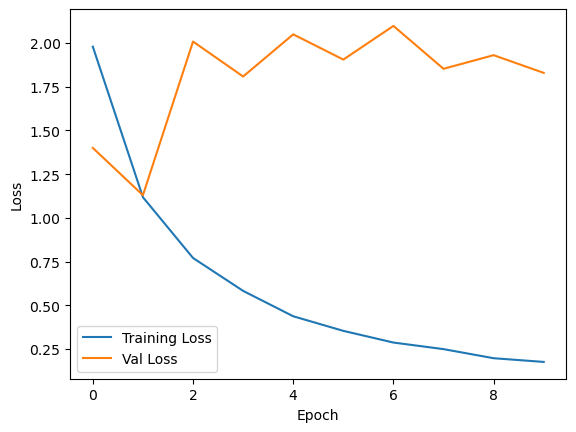

In [31]:
plotLoss(train_losses, val_losses)

### Plotting Acccuracy

In [32]:
def plotAccuracy(trainingAcc, valAcc):
    plt.plot(trainingAcc)
    plt.plot(valAcc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(["Training Accuracy", "Val Accuracy"])

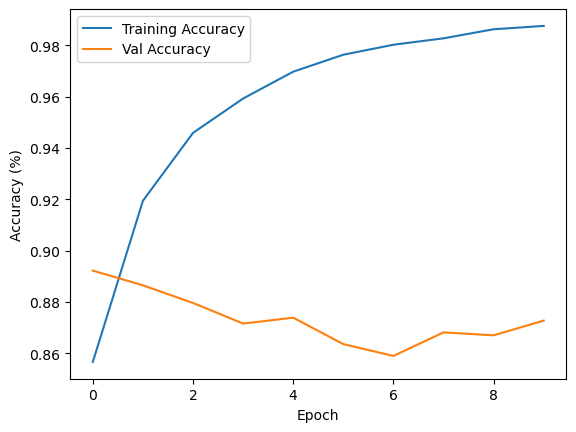

In [33]:
plotAccuracy(train_accs, val_accs)

## 6. Evaluation

In [34]:
best_weight = torch.load('./best_weights/MetaKD_TinyBert_student_model.pt')

In [35]:
student_model.load_state_dict(best_weight['model_state_dict'])

<All keys matched successfully>

### Teacher Model Accuracy

In [37]:
eval_loop(teacher_model, eval_dataloader, device)[0]['accuracy']

0.9505

### Student Model Accuracy

In [38]:
eval_loop(student_model, eval_dataloader, device)[0]['accuracy']

0.921